## IBM Debater® Claim Sentences Search

Data Source: https://developer.ibm.com/exchanges/data/all/claim-sentences-search/

Claims are short phrases that an argument aims to prove. The goal of the Claim Sentence Search task is to detect sentences containing claims in a large corpus, given a debatable topic or motion. The dataset contains results of the q_mc query – sentences containing a certain topic, as described in the paper – containing 1.49M sentences. In addition, the dataset contains a claim sentence test set containing 2.5k top predicted sentences of our model, along with their labels. The sentences were retrieved from Wikipedia 2017.

The dataset includes:
  - readme_mc_queries.txt – Readme of the claim sentence search results
  - readme_test_set.txt – Readme of the test set
  - q_mc_train.csv – Sentences retrieved by the q_mc query on 70 train topics
  - q_mc_heldout.csv – Sentences retrieved by the q_mc query on 30 heldout topics
  - q_mc_test.csv – Sentences retrieved by the q_mc query on 50 test topics
  - test_set.csv – Top predictions of our system along with their labels

In [1]:
from IPython.display import clear_output

In [2]:
!pip install wordcloud
clear_output()

In [3]:
!pip install gensim
clear_output()

In [4]:
!pip install --user -U nltk
clear_output()

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

stemmer = SnowballStemmer('english')

import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/djalova/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Download Dataset with ParData

The ParData package will download the DAX dataset and load the training set as a Pandas dataframe.

In [6]:
import pardata
pardata.list_all_datasets()

{'claim_sentences_search': ('1.0.2',),
 'concept_abstractness': ('1.0.2',),
 'expert-in-the-loop-ai-polymer-discovery': ('1.0.0',),
 'gmb': ('1.0.2',),
 'noaa_jfk': ('1.1.4',),
 'taranaki-basin-curated-well-logs': ('1.0.0',),
 'thematic_clustering_of_sentences': ('1.0.2',),
 'wikipedia_category_stance': ('1.0.2',),
 'wikipedia_oriented_relatedness': ('1.0.2',),
 'wikitext103': ('1.0.1',)}

In [7]:
print(pardata.describe_dataset('claim_sentences_search'))

Dataset name: IBM Debater® Claim Sentences Search
Description: Sentences from Wikipedia together with their topic.
Size: 571M
Published date: 2019-08-19
License: Attribution-ShareAlike 3.0 Unported (CC BY-SA 3.0)
Available subdatasets: train, heldout, test, test_set


In [8]:
claim_sentences_dataset = pardata.load_dataset('claim_sentences_search')
train_data = claim_sentences_dataset['train']

# Data Exploration and Data Visualization

In [9]:
# Shape of the training data
train_data.shape

(844302, 7)

In [10]:
# Training data column names
train_data.columns

Index(['id', 'topic', 'mc', 'sentence', 'suffix', 'prefix', 'url'], dtype='object')

### Column name description

1. id - the topic id, as specified in the appendix of the paper `Towards an argumentative content search engine using weak supervision Ran Levy, Ben Bogin, Shai Gretz, Ranit Aharonov and Noam Slonim COLING 2018`
2. topic - the motion topic
3. mc - the main Wikipedia concept of the topic
4. sentence
5. suffix - the suffix of the sentence following the mention of the mc
6. prefix - the prefix of the sentence preceding the mention of the mc
7. url - link to source Wikipedia article

In [11]:
# Number of unique ids
len(pd.unique(train_data['id']))

70

In [12]:
# Get unique topics
sorted(pd.unique(train_data['topic']))

['Academic freedom is not absolute',
 'Assisted suicide should be a criminal offence',
 'Casinos bring more harm than good',
 'Chain stores bring more harm than good',
 'Child labor should be legalized',
 'Coaching brings more harm than good',
 'Ecotourism brings more harm than good',
 'Generic drugs bring more harm than good',
 'Global warming is a major threat',
 'Homeschooling brings more good than harm',
 'IKEA brings more harm than good',
 'Illegal immigration brings more harm than good',
 'Internet censorship brings more good than harm',
 'Internet cookies bring more harm than good',
 'Magnet schools bring more harm than good',
 'Mixed-use development is beneficial',
 'Nationalism does more harm than good',
 'Newspapers are outdated',
 'Operation Cast Lead was justified',
 'PayPal brings more good than harm',
 'Private universities bring more good than harm',
 'Quebecan independence is justified',
 'Reality television does more harm than good',
 'Religion does more harm than good

In [13]:
# Number of unique topics
len(pd.unique(train_data['topic']))

70

In [14]:
# Number of data points under specific id and topic
train_data.groupby(['id','topic']).size().reset_index().rename(columns={0:'count'}).head()

,id,topic,count
0,1,We should ban the sale of violent video games ...,341
1,10,The free market brings more good than harm,3115
2,11,We should ban child actors,2123
3,12,Religion does more harm than good,135059
4,13,We should ban cosmetic surgery,3283


In [15]:
# Total number of words in the document
train_data['sentence'].apply(lambda x: len(x.split(' '))).sum()

20222150

In [16]:
# Get unique main content 
main_content = pd.unique(train_data['mc'])

In [17]:
main_content

<StringArray>
[                                  'YouTube',
                  'Video game controversies',
                            'Libertarianism',
                            'Global warming',
                          'Assisted suicide',
                        'Gaza War (2008–09)',
                               'Tower block',
                             'Homeschooling',
                            'Beauty pageant',
                                'Ecotourism',
                               'Nationalism',
 'Atomic bombings of Hiroshima and Nagasaki',
                          'Academic freedom',
                                    'Casino',
                           'Doping in sport',
                            'United Nations',
                            'Age of consent',
                               'Hate speech',
                        'Energy development',
                              'Independence',
                              'Child labour',
                    

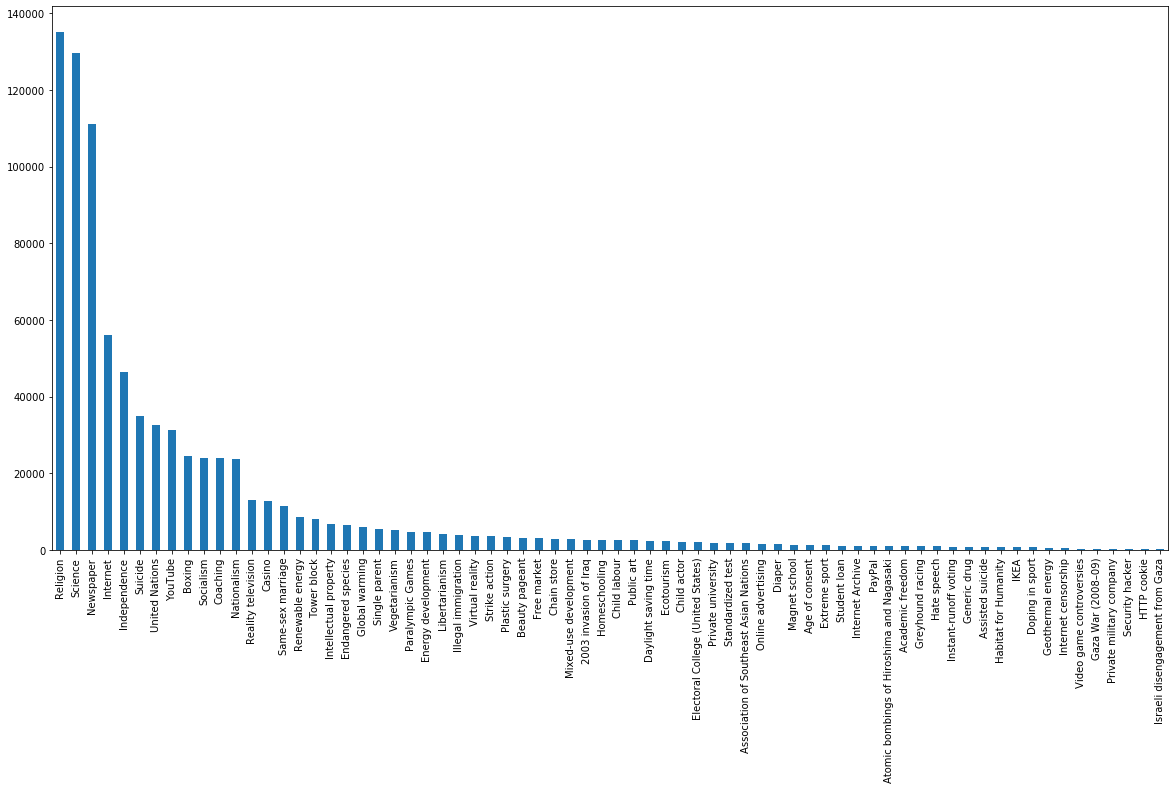

In [18]:
plt.figure(figsize=(20,10))
train_data.mc.value_counts().plot(kind='bar');

### Explore `HTTP Cookie` topic

In [19]:
# Get all data points under the topic HTTP Cookies
http_cookies_data = train_data[train_data['mc'] == 'HTTP cookie']

In [20]:
# Total data points under the topic
http_cookies_data.shape

(220, 7)

In [21]:
http_cookies_data.head()

,id,topic,mc,sentence,suffix,prefix,url
662388,58,Internet cookies bring more harm than good,HTTP cookie,The ''Common Domain Cookie'' is a secure brows...,scoped to the common domain.,The ''Common Domain Cookie'' is a secure,https://en.wikipedia.org/wiki/SAML_2.0
662389,58,Internet cookies bring more harm than good,HTTP cookie,This was possible even if a customer enabled p...,[REF].,This was possible even if a customer enabled p...,https://en.wikipedia.org/wiki/Dell
662390,58,Internet cookies bring more harm than good,HTTP cookie,Zedo uses HTTP cookies to track users' browsin...,to track users' browsing and advertisement vi...,Zedo uses,https://en.wikipedia.org/wiki/Zedo
662391,58,Internet cookies bring more harm than good,HTTP cookie,Zedo uses an HTTP cookie to track users' brows...,to track users' browsing history resulting in...,Zedo uses,https://en.wikipedia.org/wiki/Zedo
662392,58,Internet cookies bring more harm than good,HTTP cookie,The browser supports most common web technolog...,", forms, CSS, as well as basic JavaScript capa...",The browser supports most common web technolog...,https://en.wikipedia.org/wiki/PlayStation_Port...


In [22]:
# Total number of words 
print(http_cookies_data['sentence'].apply(lambda x: len(x.split(' '))).sum())

5258


In [23]:
def input_preprocess(inp_sentence):
    processed_result = []
    for token in gensim.utils.simple_preprocess(inp_sentence):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            processed_result.append(token)
    return processed_result

In [24]:
# Removing stop words from the sentences
processed_http_cookies = http_cookies_data['sentence'].map(input_preprocess)

In [25]:
token_http_cookies = []
for i in processed_http_cookies:
    for j in i:
        token_http_cookies.append(j)

In [26]:
# Number of unique words after preprocessing
len(set(token_http_cookies))

1093

In [27]:
unique_tokens_http = set(token_http_cookies)

### WordCloud creation

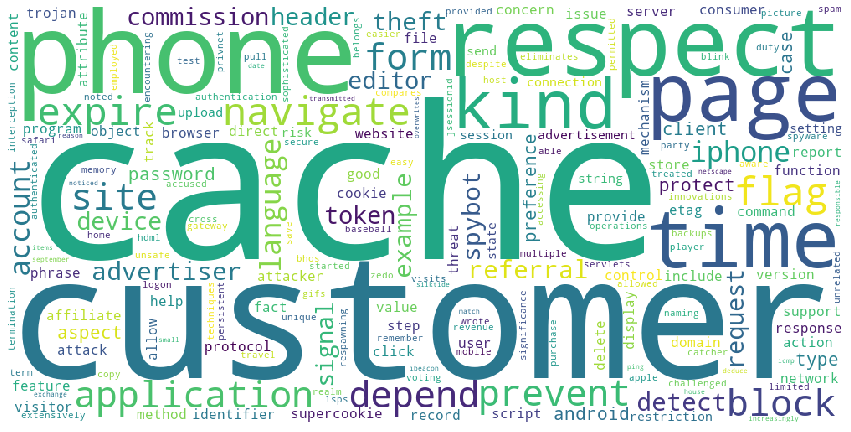

In [28]:
unique_string=(" ").join(unique_tokens_http)
wordcloud = WordCloud(width = 1000, height = 500, background_color="white").generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()
plt.close()

# Topic Modelling

In [29]:
# Pre-process documents to remove stop words 
processed_docs = train_data['sentence'].map(input_preprocess)

In [30]:
processed_docs[:5]

0    [second, annual, sidemen, charity, match, held...
1    [videos, posted, sites, youtube, generate, con...
2    [december, albarn, released, second, teaser, t...
3    [videos, later, freely, offered, tankian, webs...
4    [november, vidster, user, youtube, created, co...
Name: sentence, dtype: object

In [31]:
# Create dictionary which contain mapping between words and integer ids
dictionary = gensim.corpora.Dictionary(processed_docs)

In [32]:
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 annual
1 charity
2 held
3 match
4 second
5 sidemen
6 stars
7 taking
8 youtube
9 armenian
10 azerbaijani


In [33]:
# Total number of unique words in the dictionary
count = 0
for k, v in dictionary.iteritems():
    count += 1
    
print('Total number of words in the dictionary: ', count)

Total number of words in the dictionary:  278588


In [34]:
# Filter out tokens in the dictionary by the frequency
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=10000)

In [35]:
count = 0
for k, v in dictionary.iteritems():
    count += 1
    
print('Total number of words in the dictionary after filtering process: ', count)

Total number of words in the dictionary after filtering process:  10000


In [36]:
# Convert document into bag-of-words format. This results in a tuple containing token_id and token_count
# The output indicates that a token with a specific id appears specified number of time
# For example: (7,1) indicates token with id 7 appears 1 time.
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus[100]

[(7, 1), (45, 1), (75, 1), (103, 1), (475, 1), (476, 1)]

In [ ]:
# LDA model 
# parameters provided are document vector, number of requested latent topics, dictionary containing mapping from words IDs to word,
# and number of passes through the corpus.
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=5, id2word=dictionary, passes=1)

In [ ]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))